In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
%matplotlib inline

In [49]:
msft = yf.Ticker("MSFT")
cf = msft.cashflow
bs = msft.balance_sheet
income=msft.financials

In [91]:
cf[cf>0].isna().sum()


2019-06-30    13
2018-06-30    12
2017-06-30     8
2016-06-30     9
dtype: int64

In [39]:
cf[cf < 0].sum()


2019-06-30   -1.121940e+11
2018-06-30   -9.381300e+10
2017-06-30   -9.265700e+10
2016-06-30   -8.542100e+10
dtype: float64

In [4]:
revenue = msft.financials.loc["Total Revenue"]
total_assets = msft.balance_sheet.loc['Total Assets']

In [5]:
a = pd.concat([revenue, total_assets], axis=1)

In [6]:
a["date"] = a.index.strftime('%Y-%m-%d')

In [7]:
print(tabulate(a, headers='keys', tablefmt='psql'))

+---------------------+-----------------+----------------+------------+
|                     |   Total Revenue |   Total Assets | date       |
|---------------------+-----------------+----------------+------------|
| 2019-06-30 00:00:00 |     1.25843e+11 |    2.86556e+11 | 2019-06-30 |
| 2018-06-30 00:00:00 |     1.1036e+11  |    2.58848e+11 | 2018-06-30 |
| 2017-06-30 00:00:00 |     9.6571e+10  |    2.50312e+11 | 2017-06-30 |
| 2016-06-30 00:00:00 |     9.1154e+10  |    1.93468e+11 | 2016-06-30 |
+---------------------+-----------------+----------------+------------+


C:\Users\ruya\AppData\Local\Continuum\anaconda3\envs\quant\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


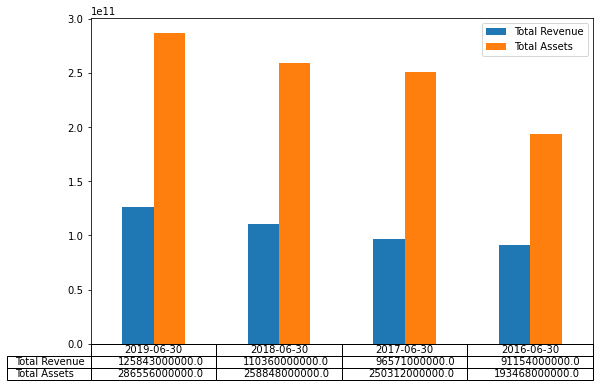

In [70]:
a.plot(x='date', kind="bar", table=True, figsize=(9,6))
ax1 = plt.axes()
x_axis = ax1.axes.get_xaxis()
x_axis.set_visible(False)
plt.show()

In [12]:
df=pd.DataFrame({'a':[1,2,3],'b':[4,5,6]})

columns=[('c','a'),('c','b')]

df.columns=pd.MultiIndex.from_tuples(columns)
print(tabulate(df, headers='keys', tablefmt='grid'))

+----+--------------+--------------+
|    |   ('c', 'a') |   ('c', 'b') |
+====+==============+==============+
|  0 |            1 |            4 |
+----+--------------+--------------+
|  1 |            2 |            5 |
+----+--------------+--------------+
|  2 |            3 |            6 |
+----+--------------+--------------+


In [72]:
ccl = yf.Ticker("FB")

In [74]:
ccl.balancesheet

,2019-12-31,2018-12-31,2017-12-31,2016-12-31
Intangible Assets,8.940000e+08,1.294000e+09,1.884000e+09,2.535000e+09
Capital Surplus,4.585100e+10,4.290600e+10,4.058400e+10,3.822700e+10
Total Liab,3.232200e+10,1.320700e+10,1.017700e+10,5.767000e+09
Total Stockholder Equity,1.010540e+11,8.412700e+10,7.434700e+10,5.919400e+10
Other Current Liab,1.085400e+10,4.494000e+09,2.590000e+09,1.937000e+09
Total Assets,1.333760e+11,9.733400e+10,8.452400e+10,6.496100e+10
Other Current Assets,8.000000e+06,1.000000e+07,1.800000e+07,NaN
Retained Earnings,5.569200e+10,4.198100e+10,3.399000e+10,2.167000e+10
Other Liab,7.327000e+09,6.190000e+09,6.417000e+09,2.892000e+09
Good Will,1.871500e+10,1.830100e+10,1.822100e+10,1.812200e+10


In [70]:
x = pd.Series([0, 0, 0, 0], index = ccl.balancesheet.columns)

In [75]:
x.sum()

0

In [84]:
mu = yf.Ticker("MU")
mu.info

{'previousClose': 48.29,
 'regularMarketOpen': 49.2997,
 'twoHundredDayAverage': 49.436234,
 'trailingAnnualDividendYield': None,
 'payoutRatio': None,
 'volume24Hr': None,
 'regularMarketDayHigh': 49.81,
 'navPrice': None,
 'averageDailyVolume10Day': 33930457,
 'totalAssets': None,
 'regularMarketPreviousClose': 48.29,
 'fiftyDayAverage': 45.519142,
 'trailingAnnualDividendRate': None,
 'open': 49.2997,
 'toCurrency': None,
 'averageVolume10days': 33930457,
 'expireDate': None,
 'yield': None,
 'algorithm': None,
 'dividendRate': None,
 'exDividendDate': None,
 'beta': None,
 'circulatingSupply': None,
 'startDate': None,
 'regularMarketDayLow': 45.35,
 'priceHint': 2,
 'currency': 'USD',
 'trailingPE': 22.836634,
 'regularMarketVolume': 39840439,
 'lastMarket': None,
 'maxSupply': None,
 'openInterest': None,
 'marketCap': 51305324544,
 'volumeAllCurrencies': None,
 'strikePrice': None,
 'averageVolume': 30800317,
 'priceToSalesTrailing12Months': None,
 'dayLow': 45.35,
 'ask': 46.64